# 1) Setup env, MinIO client, Chroma client

In [13]:
import os, json, time, hashlib
from datetime import datetime, timezone
from dotenv import load_dotenv, find_dotenv

dotenv_path = find_dotenv(filename='.env', usecwd=True)
if not dotenv_path:
    raise FileNotFoundError("Could not find .env. Set its path manually.")
print(f"Loading environment variables from {dotenv_path}")
load_dotenv(dotenv_path)

import boto3
from botocore.config import Config
import chromadb

# --- ENV ---
TRUSTED_BUCKET       = os.environ.get("TRUSTED_BUCKET", "trusted-zone")

CHROMA_PERSIST_DIR   = os.environ.get("CHROMA_PERSIST_DIR", "exploitation_zone/chroma")
RAG_TEXT_COLLECTION  = os.environ.get("RAG_TEXT_COLLECTION", "trusted_zone_documents")
RAG_CHUNKS_COLLECTION= os.environ.get("RAG_TEXT_CHUNKS", "trusted_zone_documents_chunks")

OLLAMA_HOST = os.environ.get("OLLAMA_HOST", "http://localhost:11434")
OLLAMA_MODEL = os.environ.get("OLLAMA_MODEL", "llava")

# --- MinIO S3 client ---
MINIO_USER     = os.environ.get("MINIO_USER")
MINIO_PASSWORD = os.environ.get("MINIO_PASSWORD")
MINIO_ENDPOINT = os.environ.get("MINIO_ENDPOINT")

session = boto3.session.Session(
    aws_access_key_id=MINIO_USER,
    aws_secret_access_key=MINIO_PASSWORD,
    region_name="us-east-1"
)
s3 = session.client(
    "s3",
    endpoint_url=MINIO_ENDPOINT,
    config=Config(signature_version="s3v4", s3={"addressing_style": "path"})
)


# --- Chroma client ---
CHROMA = chromadb.PersistentClient(path="../" + CHROMA_PERSIST_DIR)

def utc_ts():
    return datetime.now(timezone.utc).strftime("%Y-%m-%dT%H-%M-%SZ")


Loading environment variables from c:\Users\sindr\Documents\FIB\adsdb-multimodal-food-data-management\.env


In [14]:
# Test MinIO connection and bucket
try:
    # List all buckets
    response = s3.list_buckets()
    print("Available buckets:", [b['Name'] for b in response['Buckets']])
    
    # Check if trusted-zone bucket exists
    if TRUSTED_BUCKET in [b['Name'] for b in response['Buckets']]:
        print(f"✅ Bucket '{TRUSTED_BUCKET}' exists")
    else:
        print(f"❌ Bucket '{TRUSTED_BUCKET}' does NOT exist")
        
    # Try to list objects in the bucket
    try:
        objects = s3.list_objects_v2(Bucket=TRUSTED_BUCKET)
        print(f"Objects in {TRUSTED_BUCKET}: {objects.get('KeyCount', 0)}")
    except Exception as e:
        print(f"Cannot access bucket {TRUSTED_BUCKET}: {e}")
        
except Exception as e:
    print(f"MinIO error: {e}")

Available buckets: ['exploitation-zone', 'formatted-zone', 'landing-zone', 'trusted-zone']
✅ Bucket 'trusted-zone' exists
Objects in trusted-zone: 13


# 2) Retrieval helpers 


In [15]:
import torch
import open_clip
from PIL import Image

_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Match Chroma's default OpenCLIPEmbeddingFunction() config
_MODEL_NAME = "ViT-B-32"
_PRETRAINED = "laion2b_s34b_b79k"

_CLIP_MODEL, _CLIP_PREPROCESS, _ = open_clip.create_model_and_transforms(
    _MODEL_NAME,
    pretrained=_PRETRAINED,
    device=_DEVICE
)

@torch.no_grad()
def encode_image_to_vec(pil_img: Image.Image) -> list[float]:
    """
    Produce an OpenCLIP image embedding compatible with the vectors stored in
    the 'trusted_zone_images' Chroma collection.
    """
    img_tensor = _CLIP_PREPROCESS(pil_img).unsqueeze(0).to(_DEVICE)
    img_features = _CLIP_MODEL.encode_image(img_tensor)
    img_features = img_features / img_features.norm(dim=-1, keepdim=True)
    return img_features.squeeze(0).cpu().tolist()


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 42a02c78-7c26-47f1-8242-4a2eb5f2ba40)')' thrown while requesting HEAD https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K/resolve/main/open_clip_model.safetensors
Retrying in 1s [Retry 1/5].


In [16]:
from typing import List, Dict, Any

import base64
import io
from PIL import Image

from chromadb import PersistentClient
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction, SentenceTransformerEmbeddingFunction

ef_img = OpenCLIPEmbeddingFunction()
ef_text = SentenceTransformerEmbeddingFunction(model_name="Qwen/Qwen3-Embedding-0.6B")

def get_text_collection():
    return CHROMA.get_collection(
        name="trusted_zone_documents",
        embedding_function=ef_text,
    )

def get_image_collection():
    
    return CHROMA.get_collection(
        name="trusted_zone_images",
        embedding_function=ef_img,
    )

def retrieve_text(query: str, k: int = 5) -> Dict[str, Any]:
    """
    Retrieve top-k similar text docs from Chroma for a given natural language query.
    Returns a dict with 'hits' = [{text, meta, score}, ...]
    """
    col = get_text_collection()

    result = col.query(
        query_texts=[query],
        n_results=k,
        include=["documents", "metadatas", "distances"],
    )

    hits = []
    docs = result.get("documents", [[]])[0]
    metas = result.get("metadatas", [[]])[0]
    dists = result.get("distances", [[]])[0]

    for text_doc, meta, dist in zip(docs, metas, dists):
        hits.append({
            "text": text_doc,
            "meta": meta,
            "score": float(dist),
        })

    return {
        "query": query,
        "hits": hits,
    }

from typing import Dict, Any, Optional
from PIL import Image

def retrieve_images(
    query: Optional[str] = None,
    image_path: Optional[str] = None,
    k: int = 5,
) -> Dict[str, Any]:
    """
    Retrieve top-k similar IMAGES from Chroma.

    Modes:
      1. text→image search:
         - image_path is None
         - we pass query_texts=[query]
         - Chroma uses OpenCLIP text tower to embed the query and
           compares to stored IMAGE embeddings

      2. image→image search:
         - image_path is provided
         - we take that local image, build its OpenCLIP IMAGE embedding
           using encode_image_to_vec(...)
         - then we pass that vector as query_embeddings=[...]
    """
    col = get_image_collection()

    if image_path is not None:
        # IMAGE → IMAGE mode
        pil_img = Image.open(image_path).convert("RGB")
        img_vec = encode_image_to_vec(pil_img)  # list[float]

        result = col.query(
            query_embeddings=[img_vec],
            n_results=k,
            include=["metadatas", "distances"],
        )

    else:
        # TEXT → IMAGE mode
        result = col.query(
            query_texts=[query],
            n_results=k,
            include=["metadatas", "distances"],
        )

    metas = result.get("metadatas", [[]])[0]
    dists = result.get("distances", [[]])[0]

    hits = []
    for meta, dist in zip(metas, dists):
        hits.append({
            "image_s3_bucket": meta.get("bucket"),
            "image_s3_key": meta.get("object_key"),
            "score": float(dist),
        })

    return {"hits": hits}



def load_top_images_as_base64(image_hits, max_images=3):
    """
    Takes the image_hits list from retrieve_images() (with bucket/key),
    downloads up to max_images from MinIO,
    converts to JPEG,
    returns a list of base64-encoded strings ready for Ollama llava.
    """
    b64_list = []

    for i, hit in enumerate(image_hits):
        if i >= max_images:
            break

        bucket = hit["image_s3_bucket"]
        key = hit["image_s3_key"]

        # download from MinIO
        obj = s3.get_object(Bucket=bucket, Key=key)
        img_bytes = obj["Body"].read()

        # normalize to JPEG bytes in memory
        pil_img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        buf = io.BytesIO()
        pil_img.save(buf, format="JPEG", quality=90)
        jpeg_bytes = buf.getvalue()

        # base64 encode for Ollama
        b64_img = base64.b64encode(jpeg_bytes).decode("utf-8")
        b64_list.append({
            "bucket": bucket,
            "key": key,
            "b64": b64_img,
        })

    return b64_list


In [17]:
# Debug: Check what collections exist
print("Available collections:")
for col_name in CHROMA.list_collections():
    print(f"  - {col_name.name}")
    
# Check the specific collection
try:
    col = CHROMA.get_collection("trusted_zone_documents")
    count = col.count()
    print(f"\nCollection 'trusted_zone_documents' has {count} documents")
    
    if count > 0:
        # Get a sample
        sample = col.get(limit=2)
        print("Sample documents:")
        for i, doc in enumerate(sample['documents'][:2]):
            print(f"[{i+1}] {doc[:200]}...")
except Exception as e:
    print(f"Error accessing collection: {e}")

Available collections:
  - trusted_zone_images
  - trusted_zone_documents

Collection 'trusted_zone_documents' has 1 documents
Sample documents:
[1] title: yogurt parfaits
ingredients: 8 ounces weight light fat free vanilla yogurt used activia 1 cup fresh sliced strawberries 1 4 cups low fat granola
instructions: layer ingredients serving dish...


# 3) Prompt builder

In [18]:
def build_llava_prompt(user_query: str, text_hits: list[dict], image_hits_meta: list[dict]) -> str:
    """
    Build the instruction we will send to llava along with the actual images.

    text_hits: list of dicts with "text", "score", etc. from retrieve_text()
    image_hits_meta: list of dicts from load_top_images_as_base64() WITHOUT the base64 removed.
                     We'll pass just bucket/key info here for provenance in the prompt.
    """

    # summarize top text candidates (title + ingredients + instructions)
    summarized_text_parts = []
    for idx, hit in enumerate(text_hits[:3], 1):
        snippet = hit["text"]
        if len(snippet) > 800:
            snippet = snippet[:800] + " ..."
        summarized_text_parts.append(
            f"TEXT CANDIDATE {idx} (score {hit['score']:.4f}):\n{snippet}"
        )

    # provenance for images:
    # llava will SEE the actual images via the 'images' param to /api/generate,
    # but we still include bucket/key so it can reference them in the reasoning
    summarized_image_parts = []
    for idx, meta in enumerate(image_hits_meta[:3], 1):
        summarized_image_parts.append(
            f"IMAGE CANDIDATE {idx}: bucket={meta['bucket']} key={meta['key']}"
        )

    # generic task rules:
    RECIPE_RULES = """
You are creating ONE final recipe, dish description, or cooking plan that answers the user's request.
You are allowed to blend ideas from multiple sources (the text candidates and the images you are seeing),
but you MUST stay realistic and self-consistent.

Core requirements:
1. The output must directly address the user's request.
   - If the user asked for a recipe, return a recipe.
   - If the user asked for how to prepare something, return clear steps.
   - If the user asked for ingredients or quantities, include them.
2. Be grounded in the provided TEXT CANDIDATE recipes and the IMAGE CANDIDATE dishes.
   - Reuse ingredients, techniques, and style that you actually see or that appear in the text hits.
   - You MAY propose a small creative twist (for example combining basil from one candidate and cheese from another),
     but it must make culinary sense.
3. Keep quantities sane and readable: use units like grams, tablespoons, cloves, cups. Never output nonsense like "23 cups".
4. Consistency rule:
   - Every ingredient that appears in the Steps MUST appear in the Ingredients list.
   - Do NOT mention ingredients in the Steps that you did not list in Ingredients.
   - Do NOT invent steps that rely on equipment or processes that make no sense for the dish.
5. The Title MUST honestly describe what you're presenting. Do not claim something the dish is not.
   (Example: don't call it "Bolognese" if there is no meat ragù.)
6. At the end, include an "Inspiration" section:
   - Explain briefly which TEXT CANDIDATE numbers and IMAGE CANDIDATE numbers (1/2/3) influenced you.
   - Include the bucket/key for any IMAGE CANDIDATE you reference so we can trace it.

Output format (use this exact structure):

Title:
[short descriptive title of the dish or recipe]

Ingredients:
- [quantity + ingredient]
- [quantity + ingredient]
...

Steps:
1. [clear cooking / preparation step]
2. [clear cooking / preparation step]
3. ...

Inspiration:
Explain which TEXT CANDIDATEs and IMAGE CANDIDATEs you used and how.
Reference IMAGE CANDIDATE numbers and include their bucket/key.
"""

    prompt = f"""
The user asked:
\"\"\"{user_query}\"\"\"

We retrieved the following TEXT CANDIDATE recipes/descriptions from our dataset:
{chr(10*2).join(summarized_text_parts) if summarized_text_parts else "(no text candidates)"}

We retrieved the following IMAGE CANDIDATE dishes from our dataset.
You are currently SEEING these images (they will be provided as image inputs),
and here is their provenance for traceability:
{chr(10).join(summarized_image_parts) if summarized_image_parts else "(no image candidates)"}

Your task:
{RECIPE_RULES}
""".strip()

    return prompt


# 4) Generator

In [19]:
import httpx

def generate_with_llava(prompt: str, b64_images: list[str]) -> str:
    """
    Calls Ollama's vision model (llava) with a prompt and multiple images.
    b64_images is a list of raw base64 strings (no data: prefix).
    Returns the model's text response.
    """
    payload = {
        "model": OLLAMA_MODEL,
        "prompt": prompt,
        "images": b64_images,
        "stream": False,
    }
    print(f"Sending {len(b64_images)} images to LLaVA.")


    resp = httpx.post(f"{OLLAMA_HOST}/api/generate", json=payload, timeout=120.0)
    resp.raise_for_status()
    data = resp.json()
    return data.get("response", "").strip()

# 5) Trace saver to MinIO

In [20]:
def save_trace_to_minio(record: Dict[str, Any]) -> str:
    key = f"results/generative/rag_text/{utc_ts()}_{hashlib.sha1(record['query'].encode()).hexdigest()[:8]}.json"
    s3.put_object(
        Bucket=TRUSTED_BUCKET,
        Key=key,
        Body=json.dumps(record, ensure_ascii=False, indent=2).encode("utf-8"),
        ContentType="application/json",
    )
    return key

# 6) End-to-end RAG function for a single query

In [21]:
def run_multimodal_llava_rag(
    user_query: str,
    k: int = 5,
    user_image_path: str | None = None,
) -> dict:
    """
    Multimodal RAG pipeline (general-purpose):
    - Accepts a text query and optionally an image (e.g. a user-uploaded dish or animal photo).
    - Performs retrieval (text + image similarity) depending on available inputs.
    - Builds a multimodal prompt.
    - Calls LLaVA with both the user-provided image (if any) and top retrieved images.
    - Returns a structured record including answer, references, and provenance.

    Args:
        user_query: text question or request.
        k: number of retrieved items per modality.
        user_image_path: optional local path to an input image from the user.
    """

    # ------------------------
    # 1. Retrieve relevant documents and images
    # ------------------------
    text_res = retrieve_text(user_query, k=k)
    text_hits = text_res["hits"]

    # If the user provided an image, we can use image-based retrieval
    # (you can decide whether to always combine it with text retrieval or not)
    if user_image_path:
        print("Performing image-based retrieval using the user-provided image...")
        img_res = retrieve_images(image_path=user_image_path, k=k)
    else:
        img_res = retrieve_images(query=user_query, k=k)


    image_hits = img_res["hits"]

    # ------------------------
    # 2. Prepare images for LLaVA
    # ------------------------
    # Load top retrieved images (converted to base64 for LLaVA)
    top_images_b64 = load_top_images_as_base64(image_hits, max_images=3)
    b64_list_for_llava = [img["b64"] for img in top_images_b64]

    # If the user uploaded an image, include it first in the list so LLaVA "sees" it
    if user_image_path:
        from PIL import Image
        import base64, io

        pil_img = Image.open(user_image_path).convert("RGB")
        buf = io.BytesIO()
        pil_img.save(buf, format="JPEG", quality=90)
        user_img_b64 = base64.b64encode(buf.getvalue()).decode("utf-8")
        b64_list_for_llava.insert(0, user_img_b64)  # prepend user image

    # ------------------------
    # 3. Build prompt
    # ------------------------
    # We'll make the instructions automatically adapt to the query type
    if user_image_path:
        context_role = (
            "You are a culinary vision assistant. The user gave you an image of a dish. "
            "You MUST start by understanding that uploaded image. "
            "Then, if helpful, you can use the retrieved references as supporting context."
        )
    else:
        context_role = (
            "You are a culinary assistant. The user asked a question about food. "
            "Use the retrieved references below to answer."
            "the user HAS NOT provided an image, the images you see are not the user's image"
        )

    prompt = f"""
{context_role}

User request:
\"\"\"{user_query}\"\"\"

===== CONTEXT YOU CAN USE =====
You have access to:
1. TEXT_CANDIDATES — recipes, titles, or ingredient lists retrieved from our database that are semantically similar to the user's request or uploaded image.
2. IMAGE_CANDIDATES — images visually related to the user's request or uploaded image.
3. Optionally, a USER-UPLOADED IMAGE, which should be treated as the target dish when present.

TEXT_CANDIDATES:
{chr(10).join(
    f"- TEXT {i+1} (score {h['score']:.4f}): {h['text'][:200]}..."
    for i, h in enumerate(text_hits[:3])
) if text_hits else "(no text candidates found)"}

IMAGE_CANDIDATES (visual references from the database):
{chr(10).join(
    f"- IMAGE {i+1}: bucket={meta['bucket']}, key={meta['key']}"
    for i, meta in enumerate(top_images_b64)
) if top_images_b64 else "(no image candidates found)"}

If the user has uploaded an image, the FIRST image you receive corresponds to that dish.

===== INSTRUCTIONS =====
Your goal is to **intelligently assist the user with any food- or recipe-related query.**
You may need to do one or more of the following depending on the request:

1. **Dish Identification (Image-Based Queries)**
   - If the user uploaded an image, describe what dish or ingredients it likely shows.
   - Use both the visual cues and the TEXT_CANDIDATES to infer the dish category.
   - Mention possible regional or stylistic variants if relevant.
   - If unsure, give your best reasoned guess with supporting evidence.

2. **Recipe Generation (User Asks for a Recipe)**
   - Use the USER_REQUEST and the TEXT_CANDIDATES to generate a coherent recipe.
   - Provide:
       * Dish name (most plausible title)
       * Ingredient list with sensible quantities (grams, ml, cups, etc.)
       * Ordered steps for preparation and cooking
   - Keep recipes consistent: ingredients mentioned in steps must appear in the list.

3. **Food or Cooking Knowledge Questions**
   - If the user asks *any other question* (e.g., “What goes well with pesto?”, “Why do beans need soaking?”),
     answer clearly and informatively using your general knowledge,
     optionally referencing relevant TEXT_CANDIDATES or IMAGE_CANDIDATES for examples.

4. **Mixed Queries**
   - If the user both uploads an image and asks for a recipe, combine both:
     first identify the dish from the image, then propose a matching recipe.
   - If text and image seem inconsistent, prioritize the user’s explicit query first,
     but mention the discrepancy politely (e.g., “Although the image looks like chili, your query refers to pasta...”)

===== RULES =====
- Always remain truthful to the data:
  Prefer the TEXT_CANDIDATES and IMAGE_CANDIDATES when they clearly match the query.
- NEVER fabricate unrelated dishes or ingredients.
- Do not describe a photo unless the user actually uploaded one.
- When uncertain, express plausible possibilities (“It could be either a bean stew or chili depending on seasoning.”)
- Keep explanations concise, factual, and culinary in tone.
- End every response with a short **Inspiration** section:
  *List which TEXT_CANDIDATES or IMAGE_CANDIDATES you drew from, or say that you relied on your general cooking knowledge.*

Example structure for your answer:

Dish Name (if applicable)
Ingredients
Steps
Explanation (if the question is conceptual)
Inspiration
""".strip()


    # ------------------------
    # 4. Generate answer using LLaVA
    # ------------------------
    llava_answer = generate_with_llava(prompt, b64_list_for_llava)

    # ------------------------
    # 5. Log and return
    # ------------------------
    record = {
        "query": user_query,
        "user_image_path": user_image_path,
        "prompt": prompt,
        "answer": llava_answer,
        "model_info": OLLAMA_MODEL,
        "retrieved_text": text_hits[:3],
        "retrieved_images": top_images_b64,
        "timestamp_utc": utc_ts(),
    }

    s3_key = save_trace_to_minio(record)
    record["s3_key"] = s3_key

    return record


# 7) First RAG test

We try to ask the LLM model (Llava) for a recipe containing two ingredients (tomato and basil).

We achieve so by:

- Retrieving the most relevant documents from chromadb based on the user query and appending them onto the query
- Retrieving the most relevant images from chromadb and actually feeding them to the model so that it can "see"

In [22]:
test_query = "Give me a pasta recipe with tomato and basil, include steps and quantities"

result = run_multimodal_llava_rag(test_query, k=5)

print("===== FINAL ANSWER (LLAVA) =====")
print(result["answer"])
print("\n--- Retrieved text hits (top 3) ---")
for i, h in enumerate(result["retrieved_text"], 1):
    print(f"[TEXT {i}] score={h['score']:.4f}")
    print(h["text"][:200].replace("\n"," "), "...\n")

print("\n--- Retrieved image provenance (top images actually sent to llava) ---")
for i, imgmeta in enumerate(result["retrieved_images"], 1):
    print(f"[IMG {i}] bucket={imgmeta['bucket']} key={imgmeta['key']}")


Sending 3 images to LLaVA.


HTTPStatusError: Client error '404 Not Found' for url 'http://localhost:11434/api/generate'
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/404


Displaying images actually sent to LLaVA:

[1] images/image$adsdb-multimodal-food-data-management$2025-10-25T17-44-21Z$c286b2d709037f6206e7d3a8d89d4558__000dc3e7e7_0.jpg


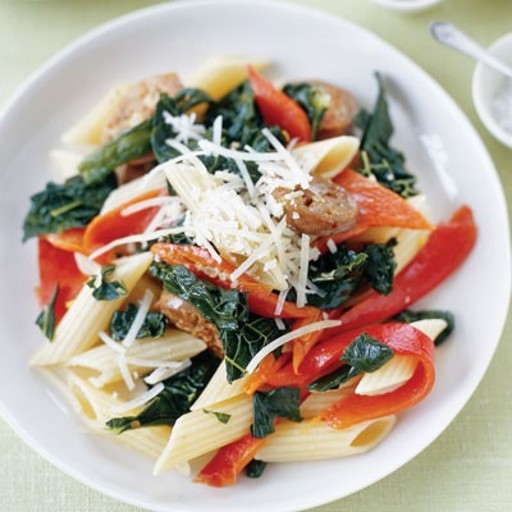

[2] images/image$adsdb-multimodal-food-data-management$2025-10-25T17-44-21Z$2ae214acf9fa1e79658ea486f850525c__00034ad6cc_2.jpg


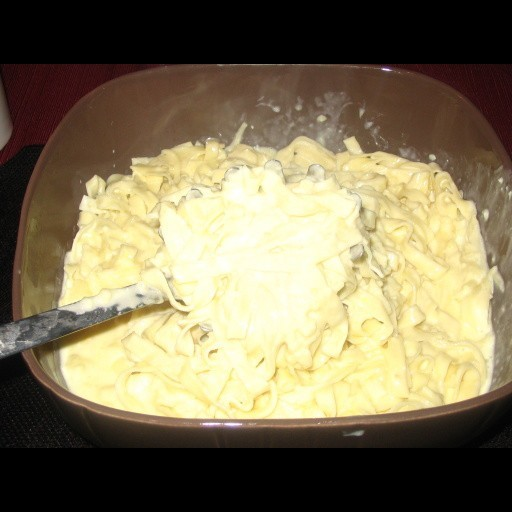

[3] images/image$adsdb-multimodal-food-data-management$2025-10-25T17-44-21Z$f81a9c593da49674756ac22f1f61e0a2__000bcc1e31_0.jpg


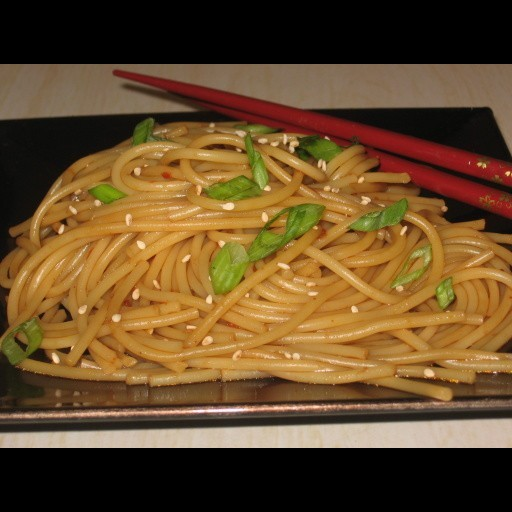

In [ ]:
from io import BytesIO
from PIL import Image
from IPython.display import display

print("\nDisplaying images actually sent to LLaVA:\n")

for i, h in enumerate(result["retrieved_images"][:3], 1):
    bucket = h.get("bucket") or h.get("image_s3_bucket")
    key = h.get("key") or h.get("image_s3_key")
    score = h.get("score")

    print(f"[{i}] {key}")
    if score is not None:
        print(f"   (similarity score: {score:.4f})")

    # --- load the image back from MinIO (for human display) ---
    obj = s3.get_object(Bucket=bucket, Key=key)
    img_bytes = obj["Body"].read()
    img = Image.open(BytesIO(img_bytes)).convert("RGB")

    display(img)


# 8) Asking the LLM about an image

Performing image-based retrieval using the user-provided image...
Sending 4 images to LLaVA.
===== MODEL ANSWER =====
Let's dive into helping the user with their culinary vision.

After analyzing the uploaded image, I can see that it appears to show a dish similar to Calico Beans. The ingredients include ground beef, bacon, onion, ketchup, brown sugar, mustard, and vinegar. These are all typical components of this classic Southern-style dish.

To generate a recipe, I'll combine these ingredients with a familiar flavor profile. Here's what I came up with:

**Recipe: Classic Calico Beans**

Ingredients:

* 1 lb ground beef
* 12 oz smoked bacon, diced
* 2 medium onions, chopped
* 1 cup ketchup
* 2 tbsp brown sugar
* 1 tsp mustard
* Salt and pepper to taste

Steps:

1. Cook the ground beef in a large pot over medium heat until browned, breaking it up with a spoon as it cooks.
2. Add diced bacon to the pot and cook until crispy.
3. Remove the cooked bacon from the pot and set aside.
4. In t

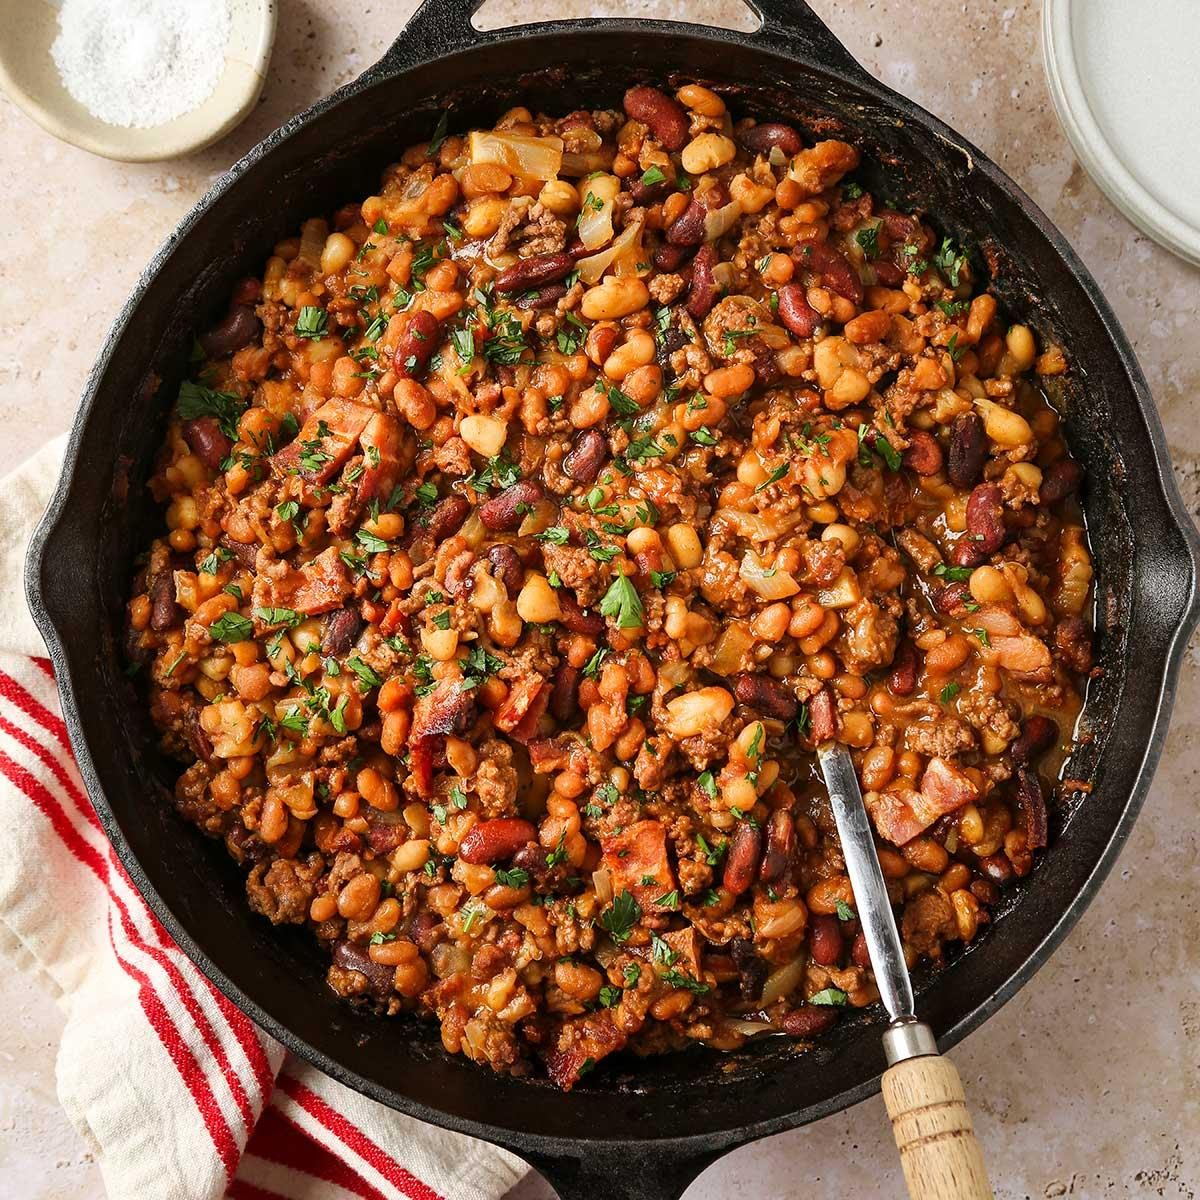

===== TOP RETRIEVED IMAGES USED AS CONTEXT =====
[1] bucket=trusted-zone key=images/image$adsdb-multimodal-food-data-management$2025-10-25T17-44-21Z$bbfd659d2c840decae3b55ac6beb9ebb__001128ebd8_0.jpg


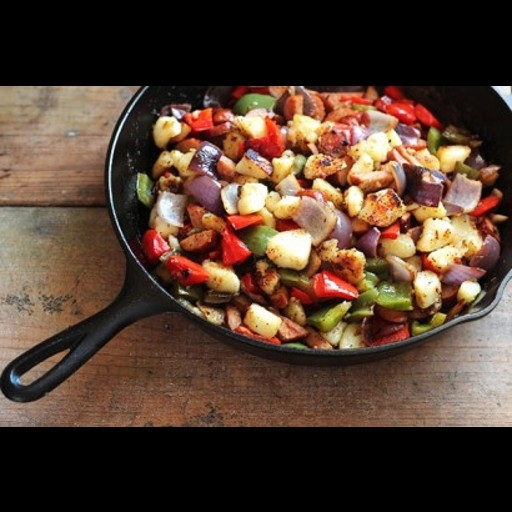

[2] bucket=trusted-zone key=images/image$adsdb-multimodal-food-data-management$2025-10-25T17-44-21Z$696e8155589b80eb0ec8cf18b083b669__0007a28fe7_0.jpg


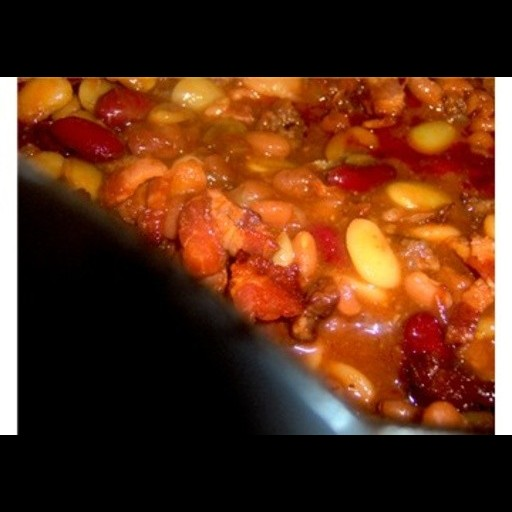

[3] bucket=trusted-zone key=images/image$adsdb-multimodal-food-data-management$2025-10-25T17-44-21Z$72b3e6e5ece452f537675217b7cc8fe1__00089c3010_0.jpg


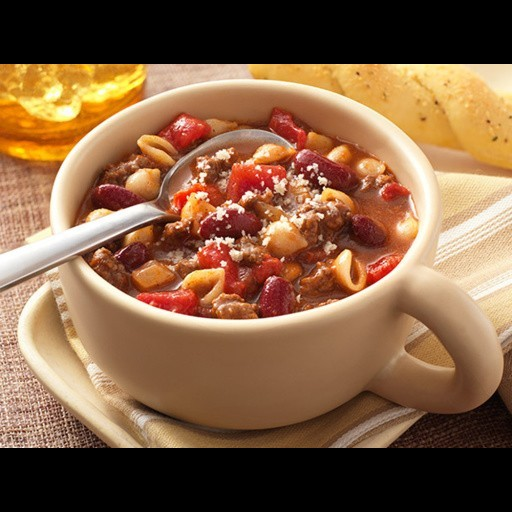

In [ ]:
# 1. User provides an example dish photo.
user_image_path = "calico-beans.jpg"

# 2. Natural language request about that image.
user_query = "Give me recipes similar to this dish. Include ingredients and steps."

# 3. Run full multimodal RAG (this calls retrieval, builds prompt, sends BOTH the user image
#    and the retrieved reference images to LLaVA, and logs the trace to MinIO)
result = run_multimodal_llava_rag(
    user_query=user_query,
    k=5,
    user_image_path=user_image_path,
)

# 4. Show model answer
print("===== MODEL ANSWER =====")
print(result["answer"])
print()

print("\n--- Retrieved text candidates ---")
for i, t in enumerate(result["retrieved_text"], 1):
    print(f"[{i}] {t['text'][:200]}...")

print("\n--- Retrieved image references ---")
for i, imgmeta in enumerate(result["retrieved_images"], 1):
    print(f"[{i}] bucket={imgmeta['bucket']} key={imgmeta['key']}")


# 5. Show the image the user uploaded
print("===== USER QUERY IMAGE =====")
display(Image.open(user_image_path).convert("RGB"))

# 6. Show the images the pipeline actually retrieved and fed to LLaVA as context
print("===== TOP RETRIEVED IMAGES USED AS CONTEXT =====")
for i, imgmeta in enumerate(result["retrieved_images"], 1):
    bucket = imgmeta["bucket"]
    key = imgmeta["key"]

    # download from MinIO
    obj = s3.get_object(Bucket=bucket, Key=key)
    img_bytes = obj["Body"].read()
    img = Image.open(io.BytesIO(img_bytes)).convert("RGB")

    print(f"[{i}] bucket={bucket} key={key}")
    display(img)
